In [2]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
# Required libraries
from pmdarima import auto_arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import warnings

# Settings and configurations
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')
register_matplotlib_converters()
RANDOM_SEED = np.random.seed(0)



In [4]:
# Load and preprocess data
df = pd.read_csv('data/metrics.csv')
df = df[['time_stamp', 'value']]
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df = df.groupby('time_stamp')['value'].sum()

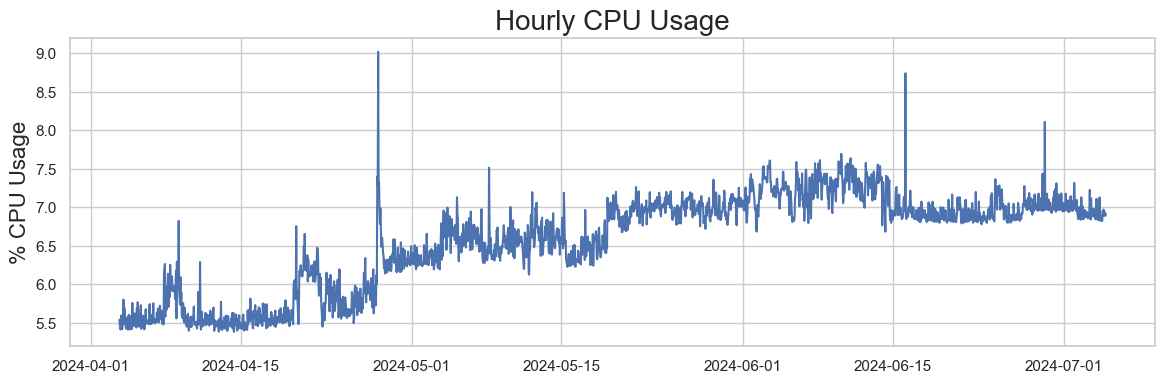

In [5]:


# Plot the time series
plt.figure(figsize=(14, 4))
plt.plot(df)
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.show()


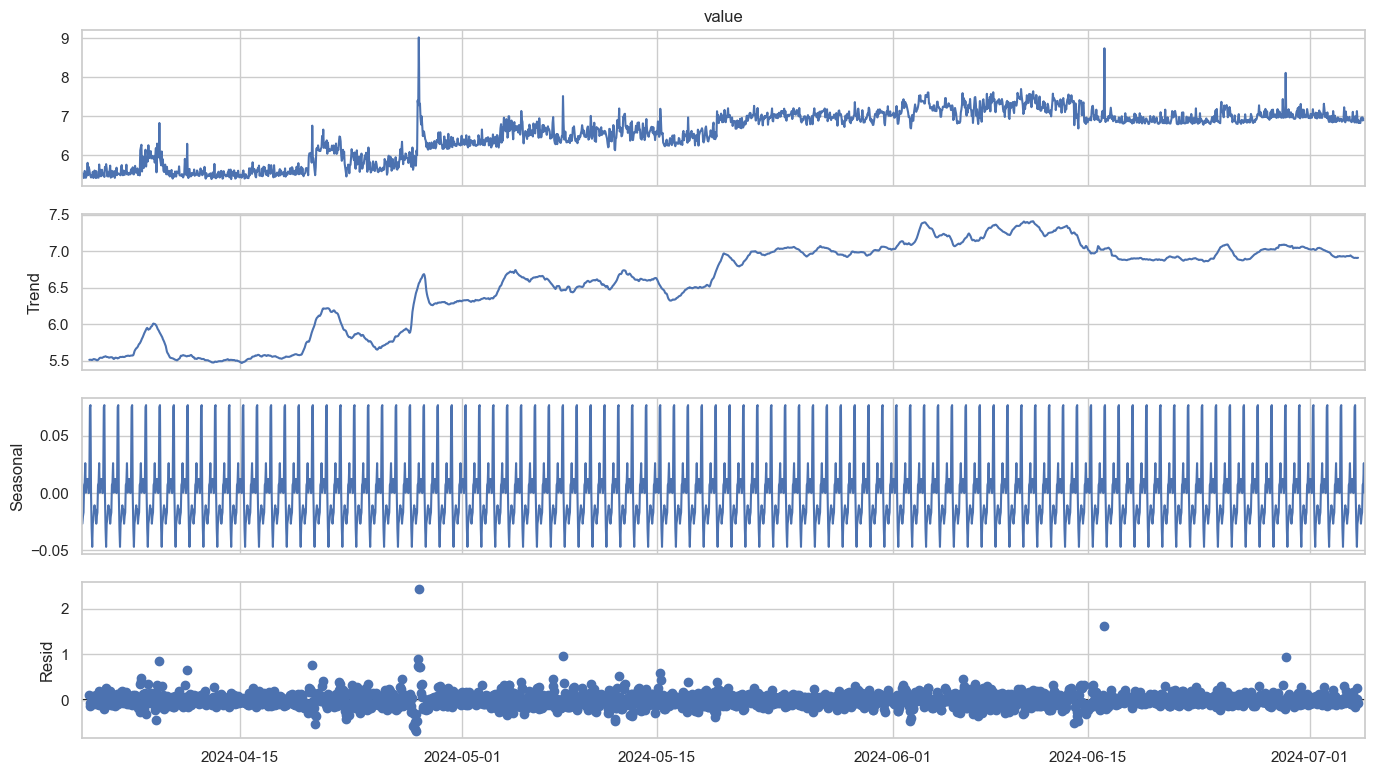

In [6]:

# STL Decomposition
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=15)
result_stl = seasonal_decompose(df, model='additive')
fig = result_stl.plot()
plt.show()

In [7]:
# Detrend the series
dt_df = df.values - result_stl.trend
dt_df = pd.Series(dt_df, index=df.index).dropna()


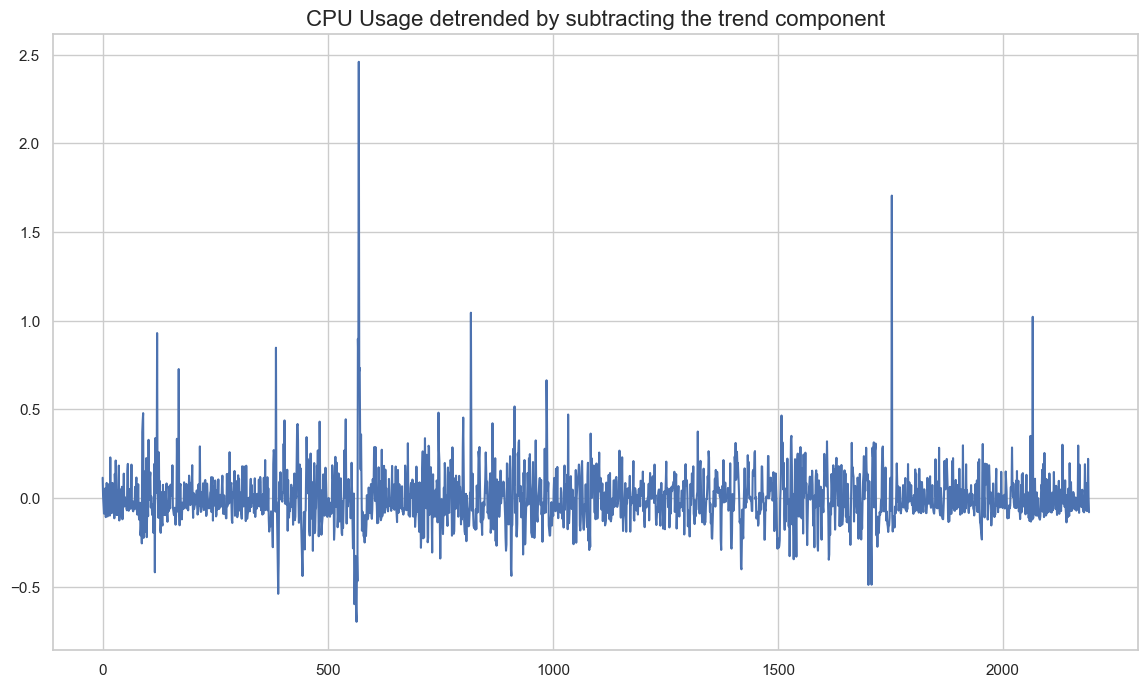

In [8]:
# Plot detrended series
plt.plot(dt_df.values)
plt.title('CPU Usage detrended by subtracting the trend component', fontsize=16)
plt.show()


In [9]:

# ADF Test for stationarity
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.9111102887584013
p-value: 0.3268526667670141


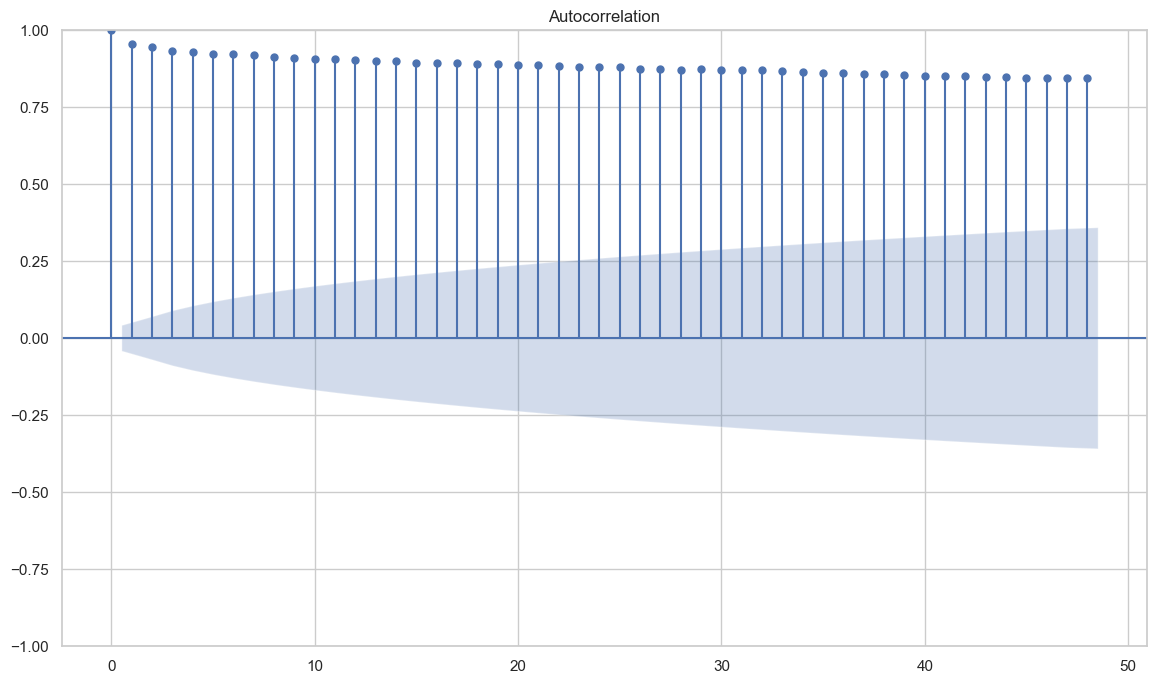

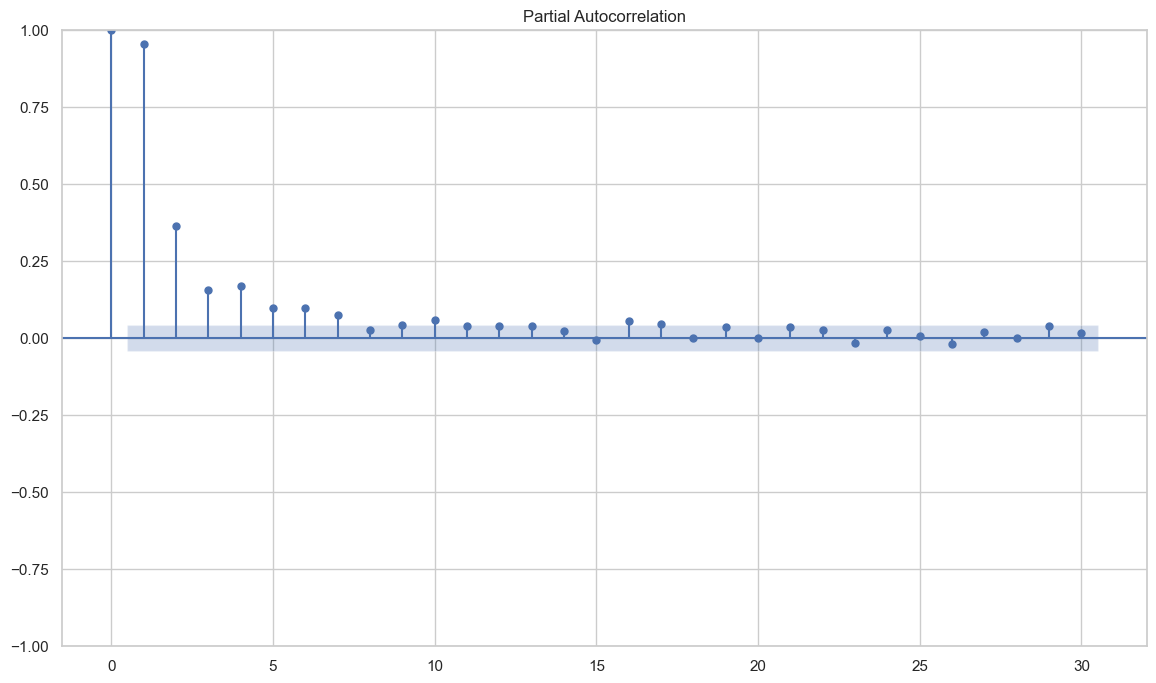

In [10]:
# ACF and PACF plots
plot_acf(df, lags=48)
plot_pacf(df, lags=30)
plt.show()

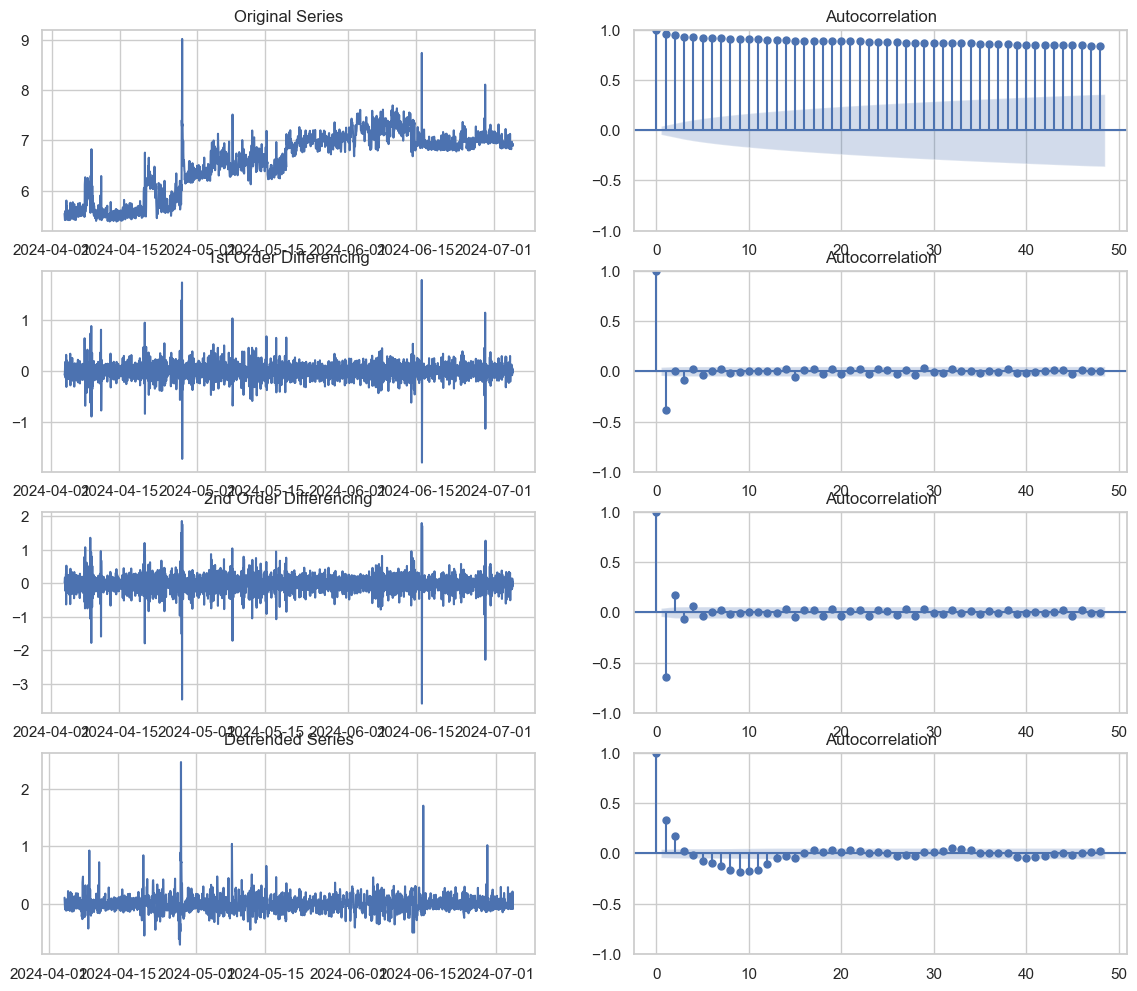

In [11]:
# Differencing to achieve stationarity
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes[0, 0].plot(df)
axes[0, 0].set_title('Original Series')
plot_acf(df, lags=48, ax=axes[0, 1])

df_1diff = df.diff().dropna()
axes[1, 0].plot(df_1diff)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_1diff, lags=48, ax=axes[1, 1])

df_2diff = df_1diff.diff().dropna()
axes[2, 0].plot(df_2diff)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_2diff, lags=48, ax=axes[2, 1])

axes[3, 0].plot(dt_df)
axes[3, 0].set_title('Detrended Series')
plot_acf(dt_df, lags=48, ax=axes[3, 1])
plt.show()


In [12]:

# ADF Test after differencing
result = adfuller(df_1diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.857359508015456
p-value: 1.740163298493059e-27
Critical Values:
   1%, -3.43333403252856
Critical Values:
   5%, -2.862858248918234
Critical Values:
   10%, -2.5674717686007003


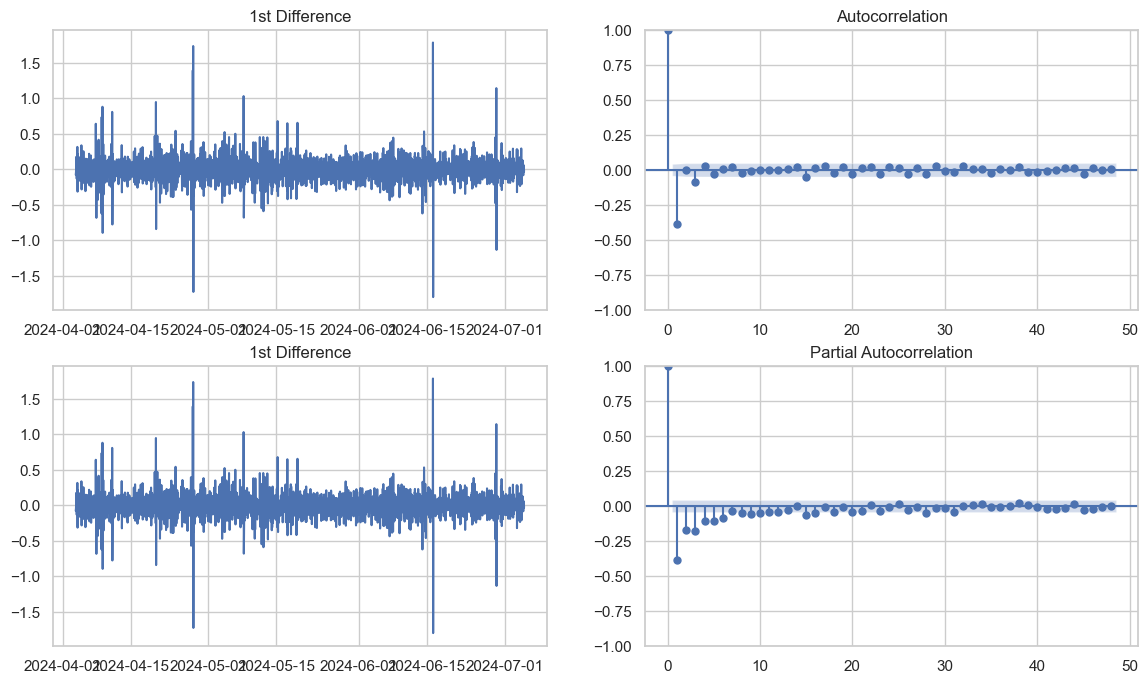

In [15]:
# ACF and PACF plots after differencing
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes[0, 0].plot(df_1diff)
axes[0, 0].set_title('1st Difference')
plot_acf(df_1diff, lags=48, ax=axes[0, 1])

axes[1, 0].plot(df_1diff)
axes[1, 0].set_title('1st Difference')
plot_pacf(df_1diff, lags=48, ax=axes[1, 1])
plt.show()



In [22]:
# Auto ARIMA model selection
arima_model = auto_arima(df, start_p=0, start_q=0,
                   max_p=3, max_q=1, m=7, start_P=0, start_Q=0, 
                   max_P=3, max_Q=1, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',   
                   suppress_warnings=True,  
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=239.315, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-722.233, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.75 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-117.264, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-981.489, Time=3.28 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-1088.897, Time=1.70 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=12.29 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.61 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-736.515, Time=1.02 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-1146.263, Time=1.78 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-1039.018, Time=0.95 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=inf, Time=7.33 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.43 sec
 ARIMA(3,1,0)(3,1,0)[7]             : AIC=-1213.672, Time=1.95 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-1111.308, T

In [25]:

# Fit the SARIMA model on the entire dataset
sarima = SARIMAX(df, order=(3, 1, 0), seasonal_order=(3, 1, 0, 7))
sarima_fit = sarima.fit()

# Forecast the next hour
forecast_next_hour = sarima_fit.forecast(steps=1)
print(f"Forecasted value for the next hour: {forecast_next_hour[0]}")



Forecasted value for the next hour: 6.858334408752613


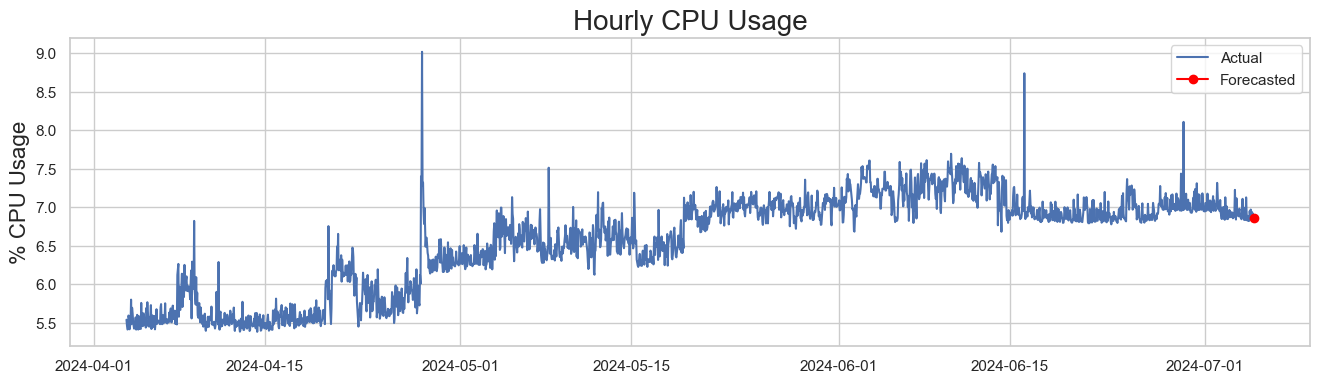

In [26]:
# Plot the actual and forecasted values
plt.figure(figsize=(16, 4))
plt.plot(df, label="Actual")
plt.plot(pd.Series(forecast_next_hour, index=[df.index[-1] + pd.Timedelta(hours=1)]), label="Forecasted", marker='o', color='red')
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()
plt.show()

Auto ARIMA model forecasted value for the next hour: 6.858334408752613


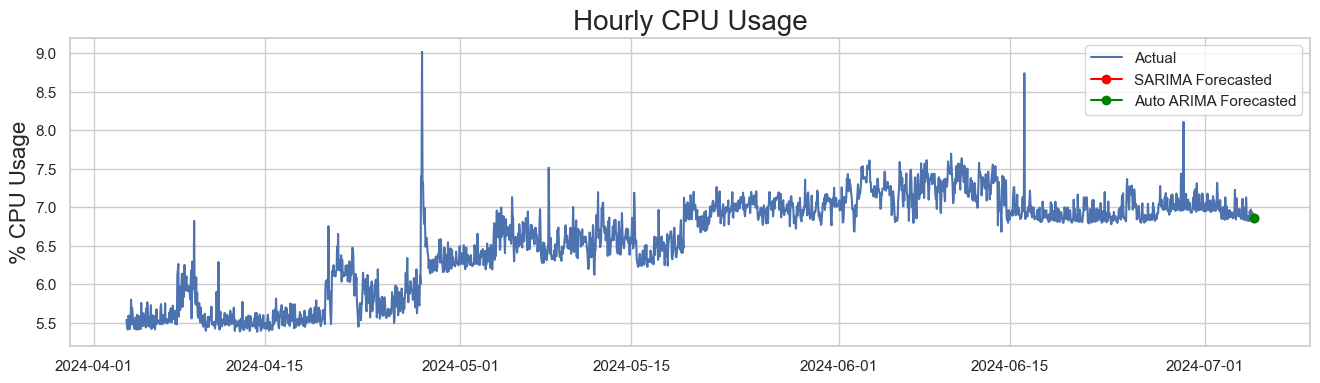

In [31]:
forecast_auto_arima_next_hour = arima_model.predict(n_periods=1)
print(f"Auto ARIMA model forecasted value for the next hour: {forecast_auto_arima_next_hour[0]}")

# Plot the actual and forecasted values from both models
plt.figure(figsize=(16, 4))
plt.plot(df, label="Actual")
plt.plot(pd.Series(forecast_next_hour, index=[df.index[-1] + pd.Timedelta(hours=1)]), label="SARIMA Forecasted", marker='o', color='red')
plt.plot(pd.Series(forecast_auto_arima_next_hour, index=[df.index[-1] + pd.Timedelta(hours=1)]), label="Auto ARIMA Forecasted", marker='o', color='green')
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()
plt.show()

In [28]:
# Display the last timestamp in the dataset
last_timestamp = df.index[-1]
print(f"Last timestamp in the dataset: {last_timestamp}")

# Determine the predicted timestamp for the next hour
predicted_timestamp = last_timestamp + pd.Timedelta(hours=1)
print(f"Predicted timestamp for the next hour: {predicted_timestamp}")

# Check if the predicted timestamp is in the dataset
is_in_dataset = predicted_timestamp in df.index
print(f"Is the predicted timestamp in the dataset? {is_in_dataset}")


Last timestamp in the dataset: 2024-07-04 23:00:00
Predicted timestamp for the next hour: 2024-07-05 00:00:00
Is the predicted timestamp in the dataset? False


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=239.315, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-722.233, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-117.264, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-981.489, Time=1.02 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-1088.897, Time=2.34 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=5.59 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.30 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-736.515, Time=1.01 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-1146.263, Time=1.45 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-1039.018, Time=1.01 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=inf, Time=6.52 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.58 sec
 ARIMA(3,1,0)(3,1,0)[7]             : AIC=-1213.672, Time=1.96 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-1111.308, Ti

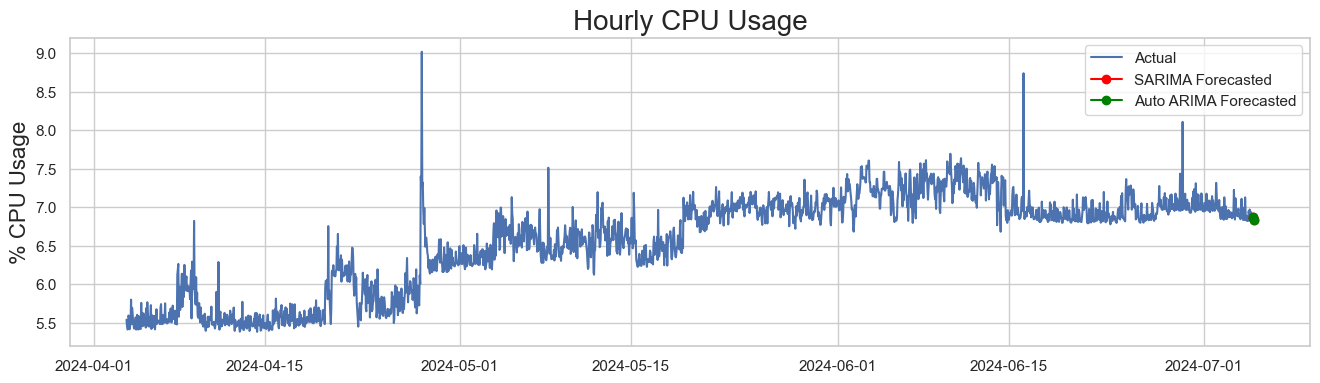

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df is already defined and preprocessed as shown in your initial code

# Fit the SARIMA model
sarima_model = SARIMAX(df, order=(3, 1, 0), seasonal_order=(3, 1, 0, 7))
sarima_fit = sarima_model.fit()
forecast_sarima_next_hours = sarima_fit.forecast(steps=3)
predicted_sarima_hours = [df.index[-1] + pd.Timedelta(hours=i) for i in range(1, 4)]

# Fit the auto_arima model on the entire dataset
auto_arima_model = pm.auto_arima(df, start_p=0, start_q=0,
                                 max_p=3, max_q=1, m=7, start_P=0, start_Q=0,
                                 max_P=3, max_Q=1, seasonal=True,
                                 d=1, D=1, trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)

# Forecast the next 2 hours using the auto_arima model
forecast_auto_arima_next_hours = auto_arima_model.predict(n_periods=3)
predicted_auto_arima_hours = [df.index[-1] + pd.Timedelta(hours=i) for i in range(1, 4)]



SARIMA model forecasted value for 2024-07-05 00:00:00: 6.858334408752613
Auto ARIMA model forecasted value for 2024-07-05 00:00:00: 6.858334408752613
SARIMA model forecasted value for 2024-07-05 01:00:00: 6.868849645184779
Auto ARIMA model forecasted value for 2024-07-05 01:00:00: 6.868849645184779
SARIMA model forecasted value for 2024-07-05 02:00:00: 6.829309729708349
Auto ARIMA model forecasted value for 2024-07-05 02:00:00: 6.829309729708349
Is the predicted SARIMA timestamp 2024-07-05 00:00:00 in the dataset? False
Is the predicted Auto ARIMA timestamp 2024-07-05 00:00:00 in the dataset? False
Is the predicted SARIMA timestamp 2024-07-05 01:00:00 in the dataset? False
Is the predicted Auto ARIMA timestamp 2024-07-05 01:00:00 in the dataset? False
Is the predicted SARIMA timestamp 2024-07-05 02:00:00 in the dataset? False
Is the predicted Auto ARIMA timestamp 2024-07-05 02:00:00 in the dataset? False


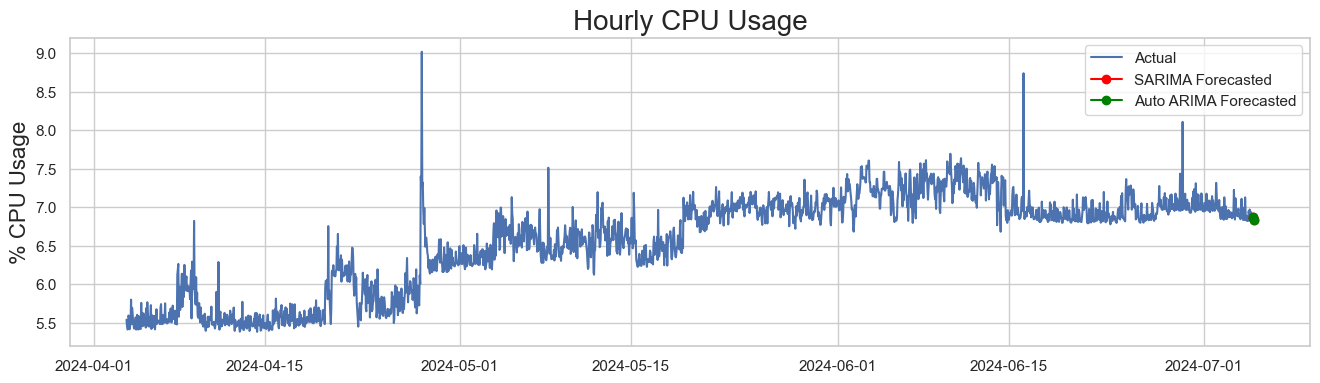

In [36]:
# Display the predicted timestamps and values
for i in range(3):
    print(f"SARIMA model forecasted value for {predicted_sarima_hours[i]}: {forecast_sarima_next_hours[i]}")
    print(f"Auto ARIMA model forecasted value for {predicted_auto_arima_hours[i]}: {forecast_auto_arima_next_hours[i]}")

# Check if the predicted timestamps are in the dataset
for i in range(3):
    print(f"Is the predicted SARIMA timestamp {predicted_sarima_hours[i]} in the dataset? {predicted_sarima_hours[i] in df.index}")
    print(f"Is the predicted Auto ARIMA timestamp {predicted_auto_arima_hours[i]} in the dataset? {predicted_auto_arima_hours[i] in df.index}")

# Plot the actual and forecasted values from both models
plt.figure(figsize=(16, 4))
plt.plot(df, label="Actual")
plt.plot(pd.Series(forecast_sarima_next_hours, index=predicted_sarima_hours), label="SARIMA Forecasted", marker='o', color='red')
plt.plot(pd.Series(forecast_auto_arima_next_hours, index=predicted_auto_arima_hours), label="Auto ARIMA Forecasted", marker='o', color='green')
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()
plt.show()
